# Latent Representation Learning for Trial-wise Movement Evaluation

In [ ]:
import pandas as pd

merged_df = pd.read_csv('/content/drive/MyDrive/differential_learning/gait_merged_dataset.csv')

In [ ]:
import torch
import torch.nn as nn

class MovementAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=32):
        super(MovementAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, bottleneck_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

In [ ]:
merged_df.columns

Index(['subject', 'trial', 'acceleration_rms_C7 Z',
       'acceleration_rms_HEAD ANT Z', 'acceleration_rms_L ACROMION Z',
       'acceleration_rms_L BACK Z', 'acceleration_rms_L ELBOW LAT Z',
       'acceleration_rms_L ELBOW MED Z', 'acceleration_rms_L FOOT LAT Z',
       'acceleration_rms_L FOOT MED Z',
       ...
       'mean_force', 'std_dev', 'range', 'skewness', 'kurtosis',
       'time_to_peak', 'velocity_rms', 'acceleration_rms', 'jerk_rms',
       'force_column'],
      dtype='object', length=498)

## Train the Autoencoder

In [ ]:
trial_uids = merged_df["trial"].copy()  # Preserve mapping

In [ ]:
features = merged_df.drop(columns=['subject', 'trial', 'force_column'])
features.head()

,acceleration_rms_C7 Z,acceleration_rms_HEAD ANT Z,acceleration_rms_L ACROMION Z,acceleration_rms_L BACK Z,acceleration_rms_L ELBOW LAT Z,acceleration_rms_L ELBOW MED Z,acceleration_rms_L FOOT LAT Z,acceleration_rms_L FOOT MED Z,acceleration_rms_L FOREARM Z,acceleration_rms_L GTROCH Z,...,velocity_rms_STERNUM Z,mean_force,std_dev,range,skewness,kurtosis,time_to_peak,velocity_rms,acceleration_rms,jerk_rms
0,0.447926,0.401833,0.421088,0.403321,0.418158,0.476067,1.357578,1.404051,0.366260,0.544838,...,2.678009,13.900952,31.120518,129.420827,0.875463,-0.045381,0.84,4.730488,2.378627,1.957071
1,0.410780,0.368904,0.387242,0.388864,0.405669,0.446333,1.357561,1.312531,0.358615,0.452321,...,2.293161,13.684933,29.891575,104.514043,1.963061,2.209504,0.54,5.627697,3.021859,2.489026
2,0.452565,0.392519,0.399557,0.403559,0.443693,0.461446,1.338725,1.277282,0.374600,0.535064,...,2.458409,22.088410,34.713107,125.017943,1.632017,1.413703,0.52,6.952784,4.413294,3.802364
3,0.449775,0.414457,0.437710,0.414019,0.463713,0.526340,1.458396,1.367815,0.410429,0.492329,...,2.556552,4.094964,26.812549,104.544919,1.600391,1.620548,0.52,5.114049,2.816036,2.336906
4,0.428812,0.388938,0.402477,0.382773,0.468494,0.458988,1.345365,1.293830,0.403591,0.489560,...,2.469995,8.744351,27.795629,114.940507,-0.022029,-0.127433,0.86,4.372904,2.008562,1.560971


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
input_dim = X_scaled.shape[1]
model = MovementAutoencoder(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(100):
    epoch_loss = 0
    for batch in loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model.decoder(model.encoder(inputs))
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")

Epoch 1: Loss = 30.4182
Epoch 2: Loss = 21.7286
Epoch 3: Loss = 18.0691
Epoch 4: Loss = 16.3714
Epoch 5: Loss = 14.9487
Epoch 6: Loss = 13.7208
Epoch 7: Loss = 12.6620
Epoch 8: Loss = 11.8967
Epoch 9: Loss = 11.0570
Epoch 10: Loss = 10.4696
Epoch 11: Loss = 10.1156
Epoch 12: Loss = 9.6381
Epoch 13: Loss = 9.1936
Epoch 14: Loss = 8.7807
Epoch 15: Loss = 8.4012
Epoch 16: Loss = 8.0631
Epoch 17: Loss = 7.8048
Epoch 18: Loss = 7.6574
Epoch 19: Loss = 7.5091
Epoch 20: Loss = 7.4233
Epoch 21: Loss = 7.1610
Epoch 22: Loss = 7.0361
Epoch 23: Loss = 6.8687
Epoch 24: Loss = 6.6189
Epoch 25: Loss = 6.3892
Epoch 26: Loss = 6.4356
Epoch 27: Loss = 6.3204
Epoch 28: Loss = 6.3015
Epoch 29: Loss = 6.0817
Epoch 30: Loss = 6.0906
Epoch 31: Loss = 5.9510
Epoch 32: Loss = 5.8781
Epoch 33: Loss = 5.8239
Epoch 34: Loss = 5.8442
Epoch 35: Loss = 5.7958
Epoch 36: Loss = 5.6184
Epoch 37: Loss = 5.6219
Epoch 38: Loss = 5.4793
Epoch 39: Loss = 5.5224
Epoch 40: Loss = 5.3742
Epoch 41: Loss = 5.3326
Epoch 42: Loss

In [ ]:
torch.save(model, "/content/drive/MyDrive/differential_learning/movement_autoencoder_full.pth")

## Extract per-trial reconstruction errors

In [ ]:
# Predict with trained model
model.eval()
with torch.no_grad():
    recon, _ = model(torch.tensor(X_scaled, dtype=torch.float32))
    mse = ((recon - torch.tensor(X_scaled, dtype=torch.float32))**2).mean(dim=1).numpy()

features["reconstruction_error"] = mse

In [ ]:
features["reconstruction_error"]

,reconstruction_error
0,0.059385
1,0.063822
2,0.105817
3,0.086117
4,0.096206
...,...
1137,0.049532
1138,0.042134
1139,0.050759
1140,0.049485


## Merge scores into full dataset

In [ ]:
features["trial"] = trial_uids
df_scored = merged_df.merge(features[["trial", "reconstruction_error"]], on="trial", how="left")

## Normalize error per subject

In [ ]:
df_scored["normalized_error"] = df_scored.groupby("subject")["reconstruction_error"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

In [ ]:
df_scored.to_csv('/content/drive/MyDrive/differential_learning/gait_merged_dataset_scored.csv', index=False)

## Visualize learning evolution per subject

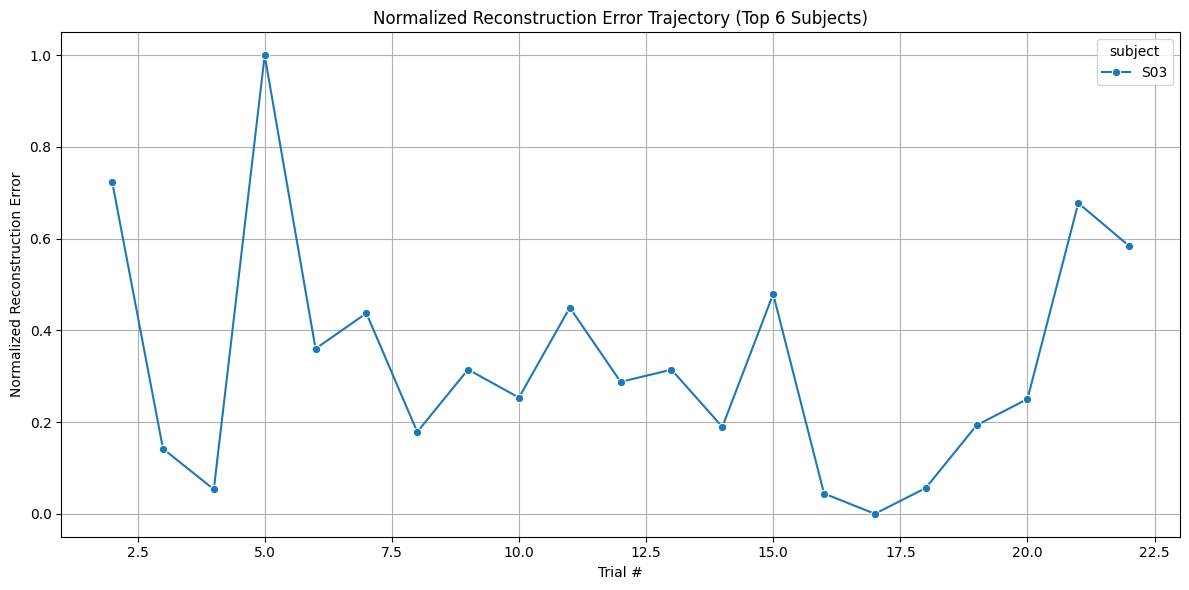

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract numeric trial index
df_scored['trial_index'] = df_scored['trial'].str.extract(r'_(\d+)_').astype(int)

# Pick top 6 subjects by trial count
top_subjects = df_scored['subject'].value_counts().head(1).index
subset_df = df_scored[df_scored['subject'].isin(top_subjects)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset_df, x='trial_index', y='normalized_error', hue='subject', marker='o')
plt.title("Normalized Reconstruction Error Trajectory (Top 6 Subjects)")
plt.xlabel("Trial #")
plt.ylabel("Normalized Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# 1. Sort by subject and trial to ensure order
df_scored = df_scored.sort_values(by=['subject', 'trial'])

# 2. Assign trial numbers per subject
df_scored['trial_number'] = df_scored.groupby('subject').cumcount() + 1

subset_subjects = sorted(df_scored['subject'].unique())[:20]
df_filtered = df_scored[df_scored['subject'].isin(subset_subjects)]

# 3. Plot with Plotly
fig = px.line(
    df_filtered,
    x='trial_number',
    y='normalized_error',
    color='subject',
    title='Normalized Reconstruction Error Trajectories (Select Subjects)',
    labels={
        'trial_number': 'Trial #',
        'normalized_reconstruction_error': 'Reconstruction Error'
    }
)

# Optional tweaks for clarity
fig.update_layout(
    height=600,
    legend_title='Subject',
    xaxis=dict(tickmode='linear'),
)

fig.show()

## Per-subject Learning Index

In [ ]:
from sklearn.linear_model import LinearRegression

learning_indices = []

for subject, group in df_scored.groupby("subject"):
    if group['trial_number'].nunique() > 1:
        x = group['trial_number'].values.reshape(-1, 1)
        y = group['normalized_error'].values
        model = LinearRegression().fit(x, y)
        slope = model.coef_[0]
        learning_indices.append({"subject": subject, "learning_index": -slope})  # negative slope = improvement

# Convert to DataFrame
learning_df = pd.DataFrame(learning_indices).sort_values(by="learning_index", ascending=False)
display(learning_df.head(50))

,subject,learning_index
29,S30,0.022755
8,S09,0.021114
54,S55,0.017284
52,S53,0.016587
50,S51,0.015793
21,S22,0.012509
22,S23,0.010087
34,S35,0.008500
12,S13,0.008177
1,S02,0.007850


In [ ]:
learning_df.to_csv('/content/drive/MyDrive/differential_learning/learning_index_all_subjects.csv', index=False)
learning_df.to_csv('/content/learning_index_all_subjects.csv', index=False)

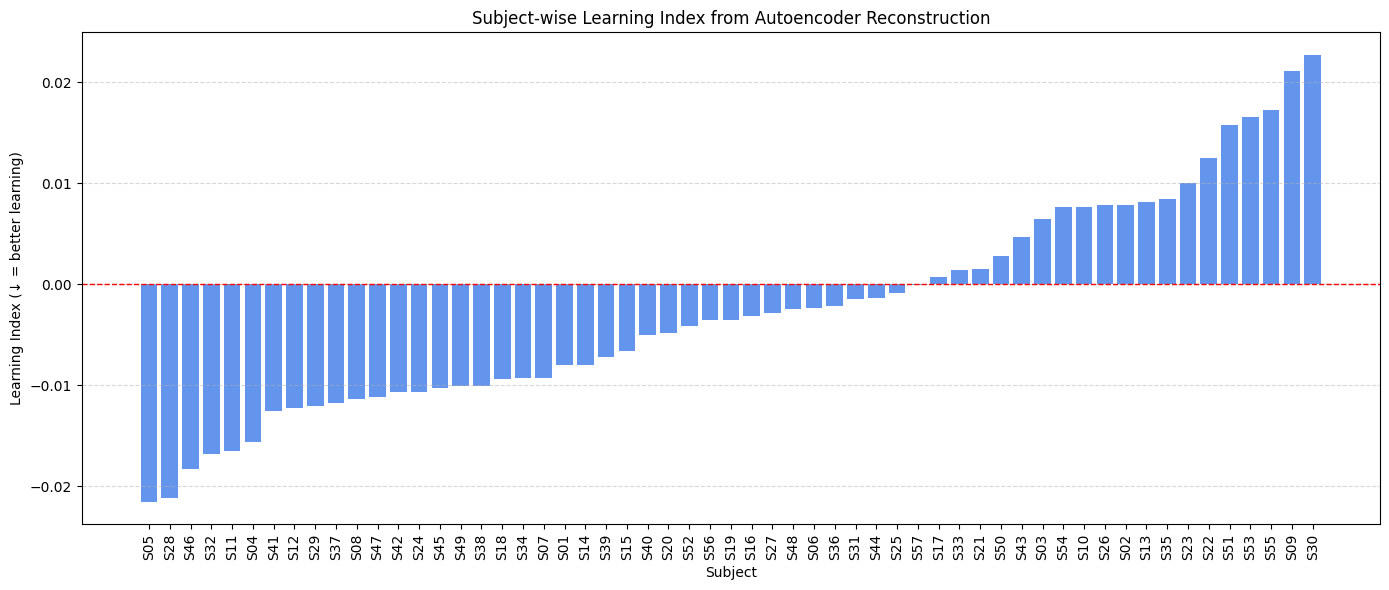

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and sort
df = pd.read_csv("/content/drive/MyDrive/differential_learning/learning_index_all_subjects.csv")
df_sorted = df.sort_values("learning_index")

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df_sorted["subject"], df_sorted["learning_index"], color="cornflowerblue")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xticks(rotation=90)
plt.xlabel("Subject")
plt.ylabel("Learning Index (↓ = better learning)")
plt.title("Subject-wise Learning Index from Autoencoder Reconstruction")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Load full trial-level scored dataset
df_scored = pd.read_csv("/content/drive/MyDrive/differential_learning/gait_merged_dataset_scored.csv")

# Merge learning index into trial-level scored dataset
df_scored = df_scored.merge(df_sorted, on="subject", how="left")

In [ ]:
df_scored.to_csv('/content/drive/MyDrive/differential_learning/gait_merged_dataset_scored_learning_index.csv', index=False)

## Matching Learning Index to Subject Physiological State

In [ ]:
import pandas as pd

# Load subject info and learning index files
info_df = pd.read_csv("/content/drive/MyDrive/differential_learning/gait_subject_info.csv",sep=";")
info_df["body_mass"] = info_df["body_mass"].str.replace(",", ".").astype(float)
info_df["height"] = info_df["Height"].str.replace(",", ".").astype(float)
info_df = info_df.drop(columns=["Height"])

learning_df = pd.read_csv("/content/drive/MyDrive/differential_learning/learning_index_all_subjects.csv")

# Preview
display(info_df.head())
display(learning_df.head())

,Subject,Gender,Age,body_mass,height
0,S01,0,29,68.9,1.75
1,S02,1,21,64.9,1.81
2,S03,0,21,80.8,1.84
3,S04,0,23,82.7,1.82
4,S05,1,26,54.9,1.63


,subject,learning_index
0,S30,0.021300
1,S02,0.018941
2,S23,0.017075
3,S09,0.016261
4,S53,0.014319


In [ ]:
# Ensure subject column is consistent
info_df.rename(columns=lambda x: x.strip().lower(), inplace=True)
if 'Subject' in info_df.columns:
    info_df.rename(columns={'Subject': 'subject'}, inplace=True)


# Merge the two dataframes
merged_df_demo = pd.merge(learning_df, info_df, on="subject", how="left")

# Preview the merged dataframe
display(merged_df_demo.head(60))

,subject,learning_index,gender,age,body_mass,height
0,S30,0.021300,0.0,28.0,81.35,1.81
1,S02,0.018941,1.0,21.0,64.90,1.81
2,S23,0.017075,0.0,21.0,69.10,1.82
3,S09,0.016261,0.0,26.0,72.00,1.84
4,S53,0.014319,0.0,20.0,69.75,1.71
5,S51,0.014019,1.0,21.0,61.80,1.67
6,S22,0.013839,1.0,26.0,56.00,1.61
7,S26,0.012629,0.0,21.0,91.20,1.99
8,S03,0.009918,0.0,21.0,80.80,1.84
9,S13,0.009041,1.0,21.0,69.70,1.69


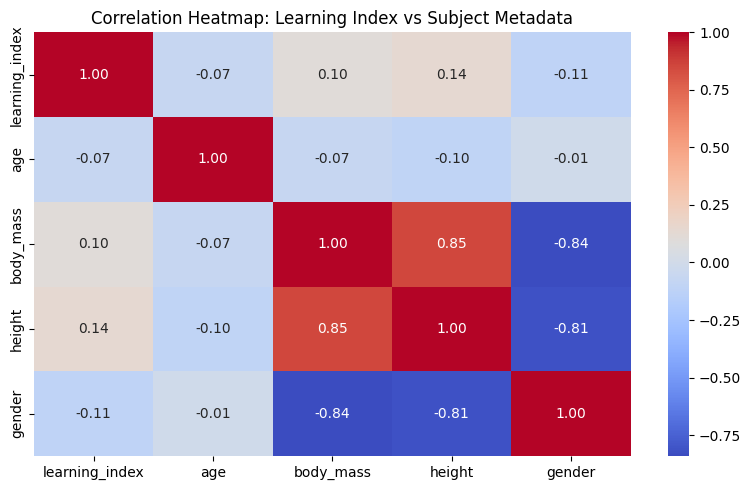

In [ ]:
# Compute correlation matrix
correlation_matrix = merged_df[["learning_index", "age", "body_mass", "height", "gender"]].corr()

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Learning Index vs Subject Metadata")
plt.tight_layout()
plt.show()

# LLM Verdict

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# === Load processed DataFrames ===
df_scored = pd.read_csv("/content/drive/MyDrive/differential_learning/gait_merged_dataset_scored.csv")
learning_df = pd.read_csv("/content/drive/MyDrive/differential_learning/learning_index_all_subjects.csv")

In [ ]:
df_scored.columns

Index(['subject', 'trial', 'acceleration_rms_C7 Z',
       'acceleration_rms_HEAD ANT Z', 'acceleration_rms_L ACROMION Z',
       'acceleration_rms_L BACK Z', 'acceleration_rms_L ELBOW LAT Z',
       'acceleration_rms_L ELBOW MED Z', 'acceleration_rms_L FOOT LAT Z',
       'acceleration_rms_L FOOT MED Z',
       ...
       'range', 'skewness', 'kurtosis', 'time_to_peak', 'velocity_rms',
       'acceleration_rms', 'jerk_rms', 'force_column', 'reconstruction_error',
       'normalized_error'],
      dtype='object', length=500)

In [ ]:
# === Normalize reconstruction error per subject for better readability ===
df_scored["normalized_error"] = df_scored.groupby("subject")["reconstruction_error"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [ ]:
# === LLM prompt generator ===
def generate_llm_prompt(subject_id, trial_errors, learning_index, movement_summary=None):
    error_str = ", ".join([f"{val:.2f}" for val in trial_errors])
    trend = "decreasing" if learning_index < -0.01 else "increasing" if learning_index > 0.01 else "flat"

    prompt = f"""
You are a clinical movement expert analyzing subject rehabilitation.

Subject ID: {subject_id}
Normalized reconstruction errors over {len(trial_errors)} trials: [{error_str}]
Calculated learning index: {learning_index:.5f} (trend: {trend})

Task:
1. Determine whether the subject's motor performance improved, worsened, or stagnated across trials.
2. Justify your conclusion by referring to the reconstruction error pattern and the learning index.
3. Mention any outliers, plateaus, or sudden changes if visible.

Return a clear and concise expert summary.

{f"Additional movement context: {movement_summary}" if movement_summary else ""}
"""
    return prompt.strip()

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_movement_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a clinical assistant analyzing trial-by-trial motor performance evolution in a movement "
                    "rehabilitation or training context. You receive data for a specific subject consisting of "
                    "trial-wise movement metrics, reconstruction errors from a deep learning model, and an overall "
                    "learning index. Your job is to determine if the subject’s performance improved, stagnated, or worsened, "
                    "and explain why using the provided numbers."
                )
            },
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.0
    )
    return response.choices[0].message.content

In [ ]:
from IPython.display import display, Markdown
def pretty_print_response(response):
    display(Markdown(f"**LLM Response:**\n\n{response}"))

# === Interactive visualization and prompt preview ===
def display_subject_analysis_with_llm(subject_id):
    subject_df = df_scored[df_scored["subject"] == subject_id].sort_values("trial")
    subject_learning_index = learning_df[learning_df["subject"] == subject_id]["learning_index"].values[0]

    # Plot error evolution
    plt.figure(figsize=(10, 4))
    plt.plot(subject_df["trial"], subject_df["normalized_error"], marker='o')
    plt.title(f"Differential Learning Curve – Subject {subject_id}")
    plt.xlabel("Trial")
    plt.ylabel("Normalized Reconstruction Error")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Generate prompt
    prompt = generate_llm_prompt(subject_id, subject_df["normalized_error"].values, subject_learning_index)

    # Print prompt
    #print("\n🔍 Prompt sent to LLM:\n")
    #print(prompt)

    # Query LLM
    print("\nMovement Analysis:\n")
    response = call_movement_llm(prompt)
    pretty_print_response(response)

## Individual Analysis

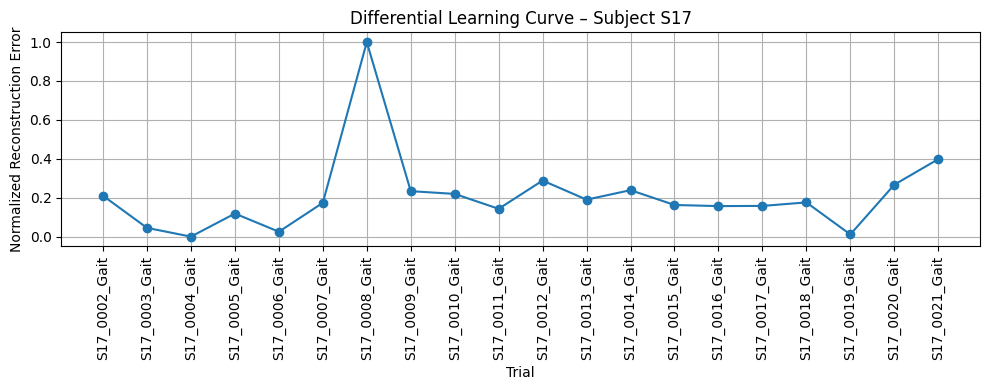


Movement Analysis:



**LLM Response:**

Subject ID: S17

1. **Performance Evaluation:**
   The subject's motor performance appears to have stagnated across the 20 trials.

2. **Justification:**
   - **Reconstruction Errors:** The normalized reconstruction errors show variability without a clear trend of improvement or worsening. The errors fluctuate throughout the trials, with some low values (e.g., 0.00 in trial 3 and 0.01 in trial 18) indicating good performance, but also some high values (e.g., 1.00 in trial 7) suggesting poor performance. This inconsistency suggests a lack of steady improvement.
   - **Learning Index:** The calculated learning index of 0.00398 with a flat trend further supports the conclusion of stagnation. A flat learning index indicates that there is no significant overall improvement or decline in performance across the trials.

3. **Additional Observations:**
   - **Outliers:** Trial 7 is a notable outlier with a reconstruction error of 1.00, which is significantly higher than the other trials and indicates a momentary lapse in performance.
   - **Plateaus:** There are periods of relatively stable performance, such as trials 14 to 16, where the reconstruction errors are consistently around 0.16, suggesting a plateau in performance.
   - **Sudden Changes:** There are sudden changes in performance, such as the drop from 0.17 in trial 6 to 1.00 in trial 7, and the subsequent return to lower errors, indicating inconsistency.

In summary, the subject's motor performance has stagnated, characterized by fluctuating reconstruction errors and a flat learning index, with notable outliers and periods of plateau.

In [ ]:
display_subject_analysis_with_llm("S17")

##  Batch Analysis

In [ ]:
# Load your datasets
df_scored = pd.read_csv("/content/drive/MyDrive/differential_learning/gait_merged_dataset_scored.csv")
df_index = pd.read_csv("/content/drive/MyDrive/differential_learning/learning_index_all_subjects.csv")

# Merge the learning index
df = df_scored.merge(df_index, on="subject", how="left")

# Select top and bottom 3 subjects
top_subjects = df_index.sort_values("learning_index", ascending=False).head(3)["subject"].tolist()
bottom_subjects = df_index.sort_values("learning_index", ascending=True).head(3)["subject"].tolist()
selected_subjects = top_subjects + bottom_subjects

# Filter the main dataframe
df_subset = df[df["subject"].isin(selected_subjects)].copy()

In [ ]:
def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a clinical assistant analyzing gait rehabilitation data."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.0
    )
    return response.choices[0].message.content

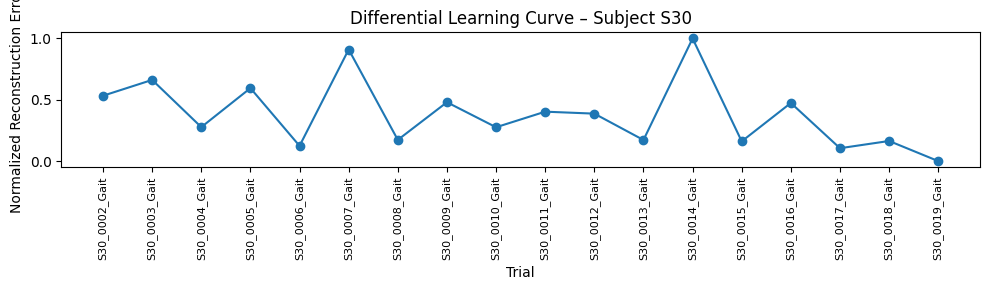

**LLM Response:**

Subject ID: S30

1. **Performance Evaluation:**
   The subject's motor performance shows an overall improvement across the 18 trials.

2. **Justification:**
   - **Reconstruction Error Pattern:** The reconstruction errors generally decrease over the course of the trials. Initially, there are higher errors (e.g., 0.533, 0.662, 0.595) with some fluctuations, but a clear downward trend is observed towards the end of the trials, culminating in a final error of 0.0. This suggests that the subject's ability to perform the task improved, as lower reconstruction errors indicate better alignment with the expected movement patterns.
   - **Learning Index:** The calculated learning index of 0.0213, although small, is positive, indicating a net improvement in performance over the trials.

3. **Additional Observations:**
   - **Outliers:** Trial 13 shows a reconstruction error of 1.0, which is a significant deviation from the surrounding trials. This could indicate an anomaly or a momentary lapse in performance.
   - **Sudden Changes:** There is a notable improvement after trial 13, with errors dropping significantly and consistently (e.g., 0.161, 0.105, 0.164, 0.0), suggesting a breakthrough or adaptation in the subject's motor performance.
   - **Plateaus:** There are no significant plateaus observed, as the errors continue to decrease towards the end.

In summary, despite some fluctuations and an outlier, the subject's motor performance improved over the trials, as evidenced by the decreasing reconstruction errors and a positive learning index.

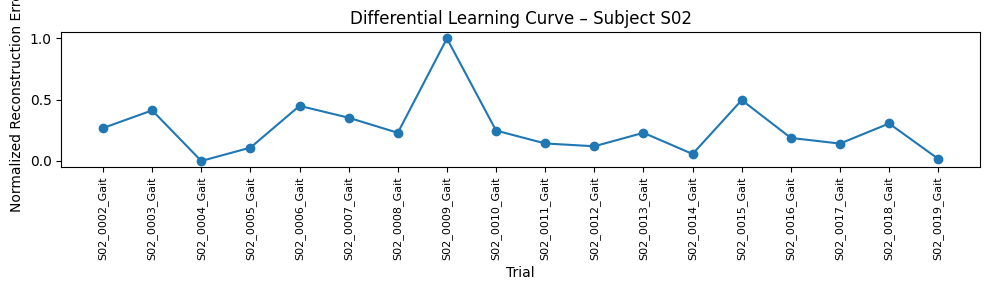

**LLM Response:**

Subject ID: S02

1. **Performance Evaluation:**
   - The subject's motor performance shows signs of improvement over the course of the 18 trials.

2. **Justification:**
   - **Reconstruction Error Pattern:** The reconstruction errors generally decrease over the trials, indicating an improvement in motor performance. Initially, there are fluctuations with some higher errors (e.g., 0.413, 0.45, 1.0), but these are interspersed with lower errors, and towards the end, the errors are consistently lower (e.g., 0.057, 0.188, 0.142, 0.017).
   - **Learning Index:** The calculated learning index of 0.01894, although small, is positive, suggesting a net improvement in performance across the trials.

3. **Additional Observations:**
   - **Outliers:** Trial 8 shows a significant spike in reconstruction error (1.0), which is an outlier compared to the surrounding trials. This could indicate a temporary lapse or difficulty in that specific trial.
   - **Sudden Changes:** There is a noticeable drop in reconstruction error after trial 8, with errors remaining relatively low and stable, indicating a potential breakthrough or adaptation in the subject's performance.
   - **Plateaus:** There are no significant plateaus observed; the errors continue to decrease towards the end of the trials.

**Expert Summary:**
The subject's motor performance has improved over the 18 trials, as evidenced by the overall decrease in reconstruction errors and a positive learning index. Despite some fluctuations and an outlier in trial 8, the trend towards lower errors in later trials suggests effective adaptation and learning.

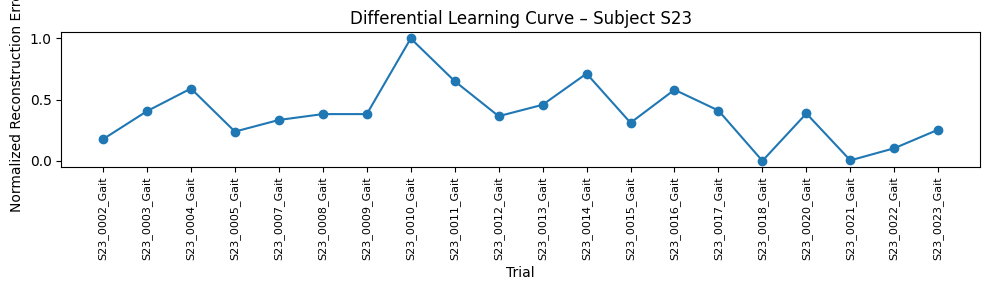

**LLM Response:**

Subject ID: S23

1. **Performance Evaluation:**
   - The subject's motor performance shows signs of improvement over the course of the 20 trials.

2. **Justification:**
   - **Reconstruction Error Pattern:** The reconstruction errors start relatively low, increase to a peak, and then generally decrease towards the end of the trials. Notably, the errors are high in the middle trials, with a peak at trial 8 (1.0), indicating a potential challenge or difficulty at that point. However, after this peak, there is a noticeable decline in errors, with the final trials showing significantly lower errors (e.g., trial 16 at 0.0, trial 18 at 0.004, and trial 19 at 0.103). This pattern suggests that the subject initially struggled but then adapted and improved their performance.
   - **Learning Index:** The calculated learning index of 0.01708, although small, is positive, indicating a net improvement in performance over the trials.

3. **Additional Observations:**
   - **Outliers:** Trial 8 is a clear outlier with a reconstruction error of 1.0, which is significantly higher than the other trials. This could indicate a specific difficulty or error during that trial.
   - **Plateaus and Sudden Changes:** There is a plateau in the middle trials (trials 5-7) where the errors are relatively stable but high. A sudden improvement is observed after trial 8, with a marked decrease in errors, suggesting a breakthrough or adaptation in the subject's performance.

**Expert Summary:**
The subject's motor performance improved over the 20 trials, as evidenced by the decreasing trend in reconstruction errors after an initial peak and a positive learning index. Despite a significant outlier at trial 8, the subject demonstrated adaptability and learning, leading to better performance in the latter trials.

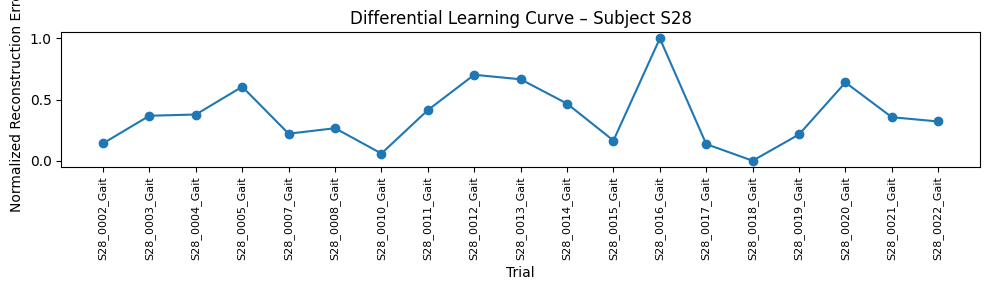

**LLM Response:**

Subject ID: S28

1. **Performance Evaluation:**
   The subject's motor performance appears to have stagnated across the trials.

2. **Justification:**
   - **Reconstruction Error Pattern:** The reconstruction errors show considerable variability without a clear trend of consistent improvement or deterioration. The errors fluctuate significantly, with some trials showing low errors (e.g., 0.059 in trial 7 and 0.0 in trial 15) and others showing high errors (e.g., 1.0 in trial 13 and 0.703 in trial 9). This inconsistency suggests that the subject's performance is not steadily improving or worsening but rather oscillating.
   - **Learning Index:** The calculated learning index of -0.02232 is close to zero, indicating minimal net change in performance over the trials. A negative value, albeit small, suggests a slight overall decline, but it is not substantial enough to indicate a clear worsening trend.

3. **Additional Observations:**
   - **Outliers:** Trial 13 shows a reconstruction error of 1.0, which is a significant outlier indicating a momentary lapse or difficulty in performance.
   - **Sudden Changes:** There are noticeable fluctuations, such as the drop from 0.666 in trial 10 to 0.467 in trial 11, and the subsequent drop to 0.165 in trial 12, followed by a spike to 1.0 in trial 13.
   - **Plateaus:** There are no clear plateaus, but the variability suggests periods of inconsistent performance rather than sustained improvement or decline.

**Expert Summary:**
The subject's motor performance has stagnated, characterized by fluctuating reconstruction errors and a near-zero learning index. The presence of outliers and sudden changes further supports the conclusion of inconsistent performance without a clear trend of improvement or deterioration.

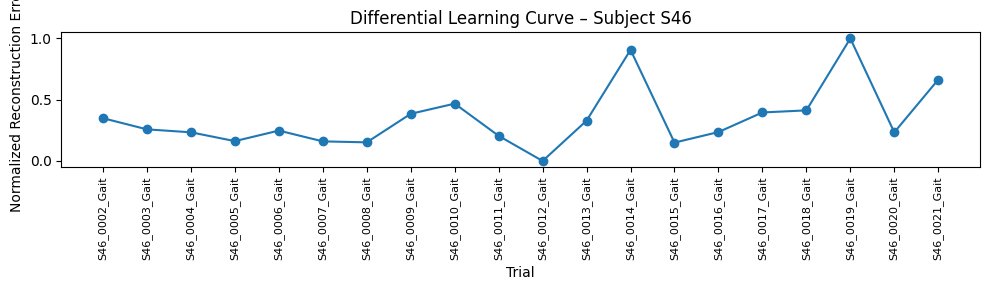

**LLM Response:**

Subject ID: S46

1. **Performance Evaluation:**
   The subject's motor performance appears to have stagnated overall, with some fluctuations in performance across the trials.

2. **Justification:**
   - **Reconstruction Errors:** The reconstruction errors show a non-linear pattern with fluctuations. Initially, there is a general trend of improvement from trial 1 to trial 7, as indicated by decreasing errors. However, this is followed by a sudden increase in error at trial 8 and a peak at trial 13. The errors then fluctuate without a clear trend towards improvement or deterioration, with another peak at trial 18.
   - **Learning Index:** The calculated learning index of -0.01953 suggests a slight negative trend, indicating that overall, there was no significant improvement in performance. This index reflects the inconsistency and lack of sustained improvement across the trials.

3. **Observations:**
   - **Outliers:** Trial 13 (error = 0.907) and trial 18 (error = 1.0) are notable outliers with significantly higher errors, indicating potential lapses in performance or external factors affecting these trials.
   - **Sudden Changes:** There is a sudden increase in error from trial 7 to trial 8 and again from trial 12 to trial 13, suggesting possible challenges or difficulties encountered by the subject during these trials.
   - **Plateaus:** The errors between trials 10 and 12, and again from trials 14 to 17, show relatively stable performance, indicating periods of plateau without significant improvement or decline.

In summary, the subject's motor performance did not show consistent improvement across the trials, as evidenced by the fluctuating reconstruction errors and a slightly negative learning index. The presence of outliers and sudden changes further supports the conclusion of stagnation in performance.

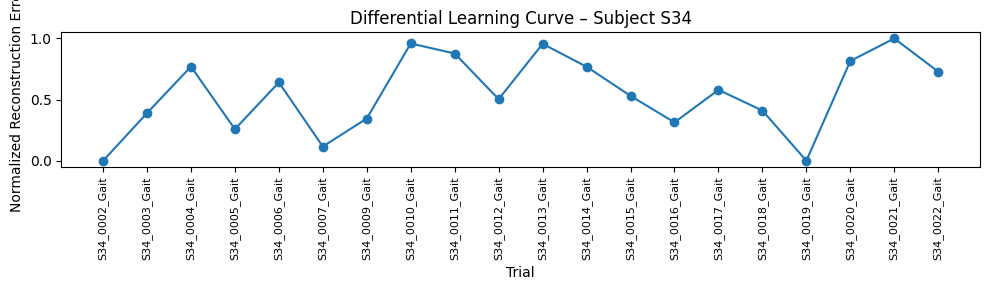

**LLM Response:**

Subject ID: S34

1. **Performance Evaluation:**
   The subject's motor performance appears to have stagnated across the 20 trials.

2. **Justification:**
   - **Reconstruction Errors:** The normalized reconstruction errors fluctuate significantly without a clear trend of improvement or worsening. The errors range from 0.0 to 1.0, with no consistent decrease or increase over the trials. This variability suggests inconsistency in performance rather than a steady improvement or decline.
   - **Learning Index:** The calculated learning index of -0.01929 is very close to zero, indicating minimal net change in performance. A negative value, albeit small, suggests a slight overall decline, but the magnitude is too small to definitively conclude worsening performance.

3. **Observations:**
   - **Outliers and Sudden Changes:** There are notable fluctuations, such as a drop from 0.77 to 0.259 between trials 3 and 4, and a spike from 0.117 to 0.346 between trials 5 and 6. These sudden changes indicate variability but do not establish a consistent trend.
   - **Plateaus:** There are no clear plateaus, as the errors continue to vary throughout the trials.

**Expert Summary:**
The subject's motor performance over the 20 trials shows significant variability with no clear trend of improvement or decline. The learning index supports this observation, indicating stagnation. The presence of fluctuations and lack of consistent improvement or decline suggest that the subject's performance has not significantly changed over the course of the trials. Further analysis or additional trials may be needed to determine long-term trends.

In [ ]:
# Loop through subjects
for subject_id in selected_subjects:
    subj_df = df_subset[df_subset["subject"] == subject_id].sort_values("trial")
    trial_ids = subj_df["trial"].tolist()
    norm_errors = subj_df["normalized_error"].round(3).tolist()
    learning_idx = subj_df["learning_index"].iloc[0]

    # Plot trajectory
    plt.figure(figsize=(10, 3))
    plt.plot(trial_ids, norm_errors, marker="o")
    plt.xticks(rotation=90, fontsize=8)
    plt.title(f"Differential Learning Curve – Subject {subject_id}")
    plt.ylabel("Normalized Reconstruction Error")
    plt.xlabel("Trial")
    plt.tight_layout()
    plt.show()

    # Create and send prompt
    prompt = f"""
You are a clinical movement expert analyzing subject rehabilitation.

Subject ID: {subject_id}
Normalized reconstruction errors over {len(norm_errors)} trials: {norm_errors}
Calculated learning index: {round(learning_idx, 5)}

Task:
1. Determine whether the subject's motor performance improved, worsened, or stagnated across trials.
2. Justify your conclusion using the reconstruction error pattern and learning index.
3. Mention any outliers, plateaus, or sudden changes if visible.

Return a clear and concise expert summary.
    """
    #print("🔍 Prompt sent to LLM:\n")
    #print(prompt.strip())
    pretty_print_response(call_movement_llm(prompt.strip()))
    print("\n" + "="*120 + "\n")